# A Finite Element Solution for a plate with MATLAB code.

The problem is show in the figure 6-16. 

![Figure 1](figure1.jpg)

This problem is show in the chapter 6.5 of the book: *A firts Course in the Finite Element Method* written by Daryl L. Logan. In this 
chapter a solution is make by subdivided the plate in two CST. The purpose of this project is to make more divisions considering 400 CST and see the results. 

## Preprocesing 

In [247]:
% Geometry definition 

%The mesh is divided in n_x*n_y squares, n_x division in the x direction and n_y divisions in the y direction. 
%At each rectangle the CST is generated joining the lower-left node with the upper-right node of the rectangle. 

t = 1; % in
E = 30*10^6; %psi
v = 0.3; 
n_x = 80; 
n_y = 80;
x0 = 0;
y0 = 0;
x1 = 20;
y1 = 10; 
x = linspace(x0,x1,n_x+1); 
y = linspace(y0,y1,n_y+1); 
%Surface Forces
p = 1000;

## Formulation and Assembly 

In [248]:
%Assembly 

%Numeration of nodes
%This function enumerate the nodes from left to right starting in the coordinate (1,1)
node_numeration = @(i,j) (j-1)*(n_x+1)+i; 

%Global matrix
n_nodes = (n_x+1)*(n_y+1); 
ndfo = 2*n_nodes; 
K = sparse(ndfo,ndfo);

%Vector of global displacements 
D = NaN(ndfo,1);
%Vector of global Forces; 
Q = NaN(ndfo,1);

%Surface force 
%The surface force is divided in each element so the force in each element is (p*L*t), then it is transmitted 
%to the nodes with the value (pLt/2) to each node. 

%Value of L
%Because of the problem L es divided in the y direction 
L = (y1-y0)/n_y;
sign_value = 1; % (-1) for comprension and (+1) for traction 
%Node force 
node_force = sign_value*p*L*t/2;

%Assembly
for i = 1:n_x
    for j = 1:n_y
        %Application of the boundary conditions 
        if i == 1
            n0 = node_numeration(i,j);
            dfo0 = [2*n0-1,2*n0];
            d = [0;0];
            D(dfo0) = d;
            %Additionally:
            if j == n_y
               %node (1,j+1) 
               n1 = node_numeration(i,j+1);
               dfo1 = [2*n1-1,2*n1]; 
               D(dfo1) = d;
            end
        end 
        
        %Calculation of surface forces and assembly of the vector of global Forces 
        if i == n_x
            n0 = node_numeration(i+1,j);
            dfo0 = [2*n0-1,2*n0];
            q = [node_force;0];
            
            if j == 1
                Q(dfo0) = q;  
            else 
                Q(dfo0) = 2*q;
            end
            
            %Additionally:  
            if j == n_y
                %node (i+1,j+1)
                n1 = node_numeration(i+1,j+1);
                dfo1 = [2*n1-1,2*n1]; 
                Q(dfo1) = q;
            end    
        end
        %Cero forces
        
        if (i>1)&&(i<=n_x)
            n0 = node_numeration(i,j);
            df0 = [2*n0-1,2*n0];
            q = [0;0];
            Q(df0) = q;
        end
        
        %Additionally
        if (i>1)&&(j == n_y)
            n0 = node_numeration(i,j+1);
            df0 = [2*n0-1,2*n0];
            q = [0;0];
            Q(df0) = q;
        end
        
        %Calculation of local stiffness matrix and assembly to global stiffness matrix 
        %The local stiffness matrix was coded in the file: "local_stiffness_matrix.m"
        %Local nodes transformed to global nodes numeration 
        n1 = node_numeration(i,j);
        n2 = node_numeration(i+1,j);
        n3 = node_numeration(i+1,j+1);
        n4 = node_numeration(i,j+1); 
        
        %Nodes coordinates
        x1 = x(i); y1 = y(j);
        x2 = x(i+1); y2 = y(j);
        x3 = x(i+1); y3 = y(j+1);
        x4 = x(i); y4 = y(j+1);
        
        %Triangle1: n1(x1,y1), n3(x3,y3), n4(x4,y4) 
        k1 = local_stiffness_matrix(x1,y1,x3,y3,x4,y4,E,v,t);
        
        %Degrees of freedom numeration 
        dfo1 = [2*n1-1,2*n1,2*n3-1,2*n3,2*n4-1,2*n4];
        
        %Assembly
        K(dfo1,dfo1) = K(dfo1,dfo1) + k1;

        %Triangle2: n1(x1,y1), n2(x2,y2), n3(x3,y3) 
        k2 = local_stiffness_matrix(x1,y1,x2,y2,x3,y3,E,v,t);
        
        %Degrees of freedom numeration 
        dfo2 = [2*n1-1,2*n1,2*n2-1,2*n2,2*n3-1,2*n3];
        
        %Assembly
        K(dfo2,dfo2) = K(dfo2,dfo2) + k2;
    end
end

## Solution of the equation Q = K*D

In [249]:
%We subdivided the matrices 
%u is used for unknown and k for known 
D_k_positions = find(~isnan(D)); %The displacements that are imposed
D_u_positions = find(isnan(D)); %The displacements that we don't known

K_uu = K(D_u_positions,D_u_positions);
K_uk = K(D_u_positions,D_k_positions);
K_kk = K(D_k_positions,D_k_positions);
K_ku = K(D_k_positions,D_u_positions);

D_u = D(D_u_positions);
D_k = D(D_k_positions);
Q_k = Q(D_u_positions);%Values of Q in the dfo where the displacements are not known 

D_u = K_uu\(Q_k-K_uk*D_k);
Q_u = K_kk*D_k+K_ku*D_u;

D(D_u_positions) = D_u;
Q(D_k_positions) = Q_u;

## Graphics 

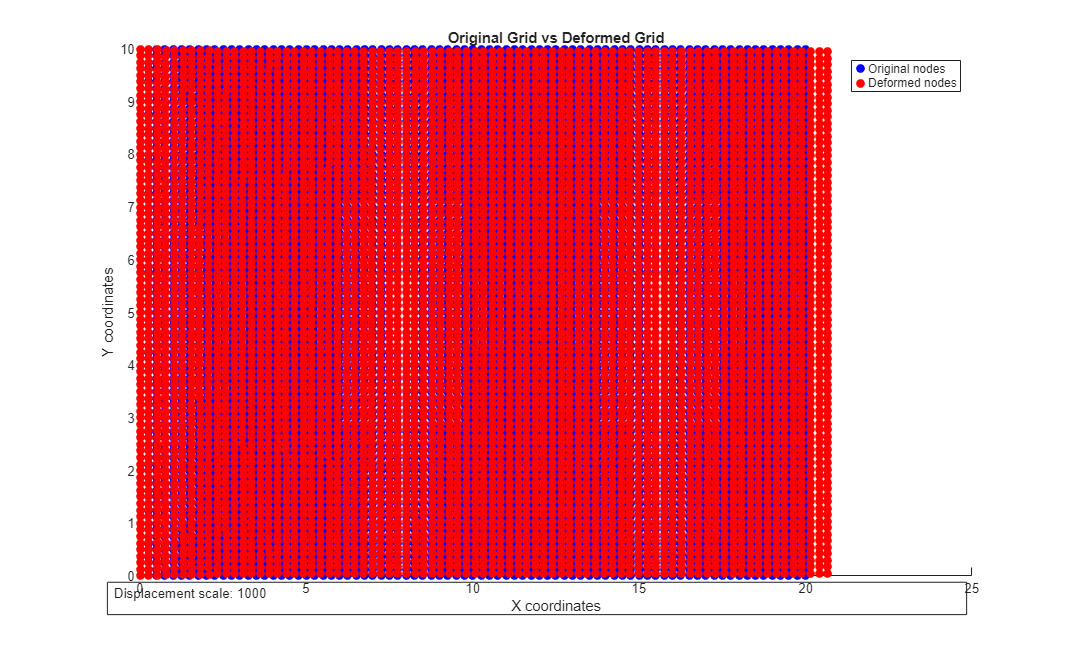

In [250]:
%Coordinates with displacements 

%Original Coordinates
[X_grid,Y_grid] = meshgrid(x,y);
X_grid_tra = X_grid';
Y_grid_tra = Y_grid';
x_points = X_grid_tra(:);
y_points = Y_grid_tra(:);
%Displacements of u for x with corresponds to the odd dfos and v for y with even dfos. 
u = D(1:2:end);
v = D(2:2:end);
displacement_scale = 1000;%to diferentiate te results

%Displacements in x and y 
x_displaced = x_points +u*displacement_scale;
y_displaced = y_points +v*displacement_scale;

%Figures 
figure;
hold on; 
% puntos originales y desplazados
plot(X_grid(:), Y_grid(:), 'bo', 'MarkerFaceColor', 'b');
plot(x_displaced, y_displaced, 'ro', 'MarkerFaceColor', 'r');
hold off; 
title('Original Grid vs Deformed Grid');
xlabel('X coordinates');
ylabel('Y coordinates');
legend('Original nodes','Deformed nodes');
note = sprintf('Displacement scale: %d', displacement_scale);
annotation('textbox', [0.1, 0.05, 0.8, 0.05], 'String', note);

In [134]:
%{%Replacing the NaN for incognites 
%Identification of the values that are NaN in the code
[x_nan_Q] = find(isnan(Q));
[y_nan_D] = find(isnan(D));
%Creating the incognites
%in Q: 
x_Q = sym(zeros(length(x_nan_Q),1));
for i = 1:length(x_nan_Q)
    x_Q(i) = sym(sprintf('Q%d',x_nan_Q(i)));
end
%in D:
y_D = sym(zeros(length(y_nan_D),1));
for i = 1:length(y_nan_D)
    y_D(i) = sym(sprintf('D%d',y_nan_D(i)));
end
x_Q
y_D
%}

%{K = full(K);
miOrdenColumnas = [1 2 5 6 7 8 3 4];
miOrdenFilas = [1 2 5 6 7 8 3 4];
K = K(miOrdenFilas, miOrdenColumnas);
K = K*(0.91/375000);
K;
%}
D

 
x_Q =
 
Empty sym: 0-by-1
 
 
y_D =
 
Empty sym: 0-by-1
 

D =

   1.0e-03 *

         0
         0
   -0.6637
   -0.1041
         0
         0
   -0.6096
   -0.0042


